### 1. Importamos las librerias

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# Generador basado en ejemplo del curso CS231 de Stanford: 
# CS231n Convolutional Neural Networks for Visual Recognition
# (https://cs231n.github.io/neural-networks-case-study/)
def generar_datos_clasificacion(cantidad_ejemplos, cantidad_clases):
    FACTOR_ANGULO = 0.79
    AMPLITUD_ALEATORIEDAD = 0.1

    # Calculamos la cantidad de puntos por cada clase, asumiendo la misma cantidad para cada 
    # una (clases balanceadas)
    n = int(cantidad_ejemplos / cantidad_clases)

    # Entradas: 2 columnas (x1 y x2)
    x = np.zeros((cantidad_ejemplos, 2))
    # Salida deseada ("target"): 1 columna que contendra la clase correspondiente (codificada como un entero)
    t = np.zeros(cantidad_ejemplos, dtype="uint8")  # 1 columna: la clase correspondiente (t -> "target")

    randomgen = np.random.default_rng()

    # Por cada clase (que va de 0 a cantidad_clases)...
    for clase in range(cantidad_clases):
        # Tomando la ecuacion parametrica del circulo (x = r * cos(t), y = r * sin(t)), generamos 
        # radios distribuidos uniformemente entre 0 y 1 para la clase actual, y agregamos un poco de
        # aleatoriedad
        radios = np.linspace(0, 1, n) + AMPLITUD_ALEATORIEDAD * randomgen.standard_normal(size=n)

        # ... y angulos distribuidos tambien uniformemente, con un desfasaje por cada clase
        angulos = np.linspace(clase * np.pi * FACTOR_ANGULO, (clase + 1) * np.pi * FACTOR_ANGULO, n)

        # Generamos un rango con los subindices de cada punto de esta clase. Este rango se va
        # desplazando para cada clase: para la primera clase los indices estan en [0, n-1], para
        # la segunda clase estan en [n, (2 * n) - 1], etc.
        indices = range(clase * n, (clase + 1) * n)

        # Generamos las "entradas", los valores de las variables independientes. Las variables:
        # radios, angulos e indices tienen n elementos cada una, por lo que le estamos agregando
        # tambien n elementos a la variable x (que incorpora ambas entradas, x1 y x2)
        x1 = radios * np.sin(angulos)
        x2 = radios * np.cos(angulos)
        x[indices] = np.c_[x1, x2]

        # Guardamos el valor de la clase que le vamos a asociar a las entradas x1 y x2 que acabamos
        # de generar
        t[indices] = clase

    return x, t

In [11]:
def inicializar_pesos(n_entrada, n_capa_2, n_capa_3):
    randomgen = np.random.default_rng()

    w1 = 0.1 * randomgen.standard_normal((n_entrada, n_capa_2))
    b1 = 0.1 * randomgen.standard_normal((1, n_capa_2))

    w2 = 0.1 * randomgen.standard_normal((n_capa_2, n_capa_3))
    b2 = 0.1 * randomgen.standard_normal((1,n_capa_3))

    return {"w1": w1, "b1": b1, "w2": w2, "b2": b2}

In [12]:
def ejecutar_adelante(x, pesos):
    # Funcion de entrada (a.k.a. "regla de propagacion") para la primera capa oculta
    z = x.dot(pesos["w1"]) + pesos["b1"]

    # Funcion de activacion ReLU para la capa oculta (h -> "hidden")
    h = np.maximum(0, z)

    # Salida de la red (funcion de activacion lineal). Esto incluye la salida de todas
    # las neuronas y para todos los ejemplos proporcionados
    y = h.dot(pesos["w2"]) + pesos["b2"]

    return {"z": z, "h": h, "y": y}

In [13]:
def clasificar(x, pesos):
    # Corremos la red "hacia adelante"
    resultados_feed_forward = ejecutar_adelante(x, pesos)
    
    # Buscamos la(s) clase(s) con scores mas altos (en caso de que haya mas de una con 
    # el mismo score estas podrian ser varias). Dado que se puede ejecutar en batch (x 
    # podria contener varios ejemplos), buscamos los maximos a lo largo del axis=1 
    # (es decir, por filas)
    max_scores = np.argmax(resultados_feed_forward["y"], axis=1)

    # Tomamos el primero de los maximos (podria usarse otro criterio, como ser eleccion aleatoria)
    # Nuevamente, dado que max_scores puede contener varios renglones (uno por cada ejemplo),
    # retornamos la primera columna
    return max_scores[:, 0]

In [14]:
# x: n entradas para cada uno de los m ejemplos(nxm)
# t: salida correcta (target) para cada uno de los m ejemplos (m x 1)
# pesos: pesos (W y b)
def train(x, t, pesos, learning_rate, epochs):
    # Cantidad de filas (i.e. cantidad de ejemplos)
    m = np.size(x, 0) 
    
    for i in range(epochs):
        # Ejecucion de la red hacia adelante
        resultados_feed_forward = ejecutar_adelante(x, pesos)
        y = resultados_feed_forward["y"]
        h = resultados_feed_forward["h"]
        z = resultados_feed_forward["z"]

        # LOSS
        # a. Exponencial de todos los scores
        exp_scores = np.exp(y)

        # b. Suma de todos los exponenciales de los scores, fila por fila (ejemplo por ejemplo).
        #    Mantenemos las dimensiones (indicamos a NumPy que mantenga la segunda dimension del
        #    arreglo, aunque sea una sola columna, para permitir el broadcast correcto en operaciones
        #    subsiguientes)
        sum_exp_scores = np.sum(exp_scores, axis=1, keepdims=True)

        # c. "Probabilidades": normalizacion de las exponenciales del score de cada clase (dividiendo por 
        #    la suma de exponenciales de todos los scores), fila por fila
        p = exp_scores / sum_exp_scores

        # d. Calculo de la funcion de perdida global. Solo se usa la probabilidad de la clase correcta, 
        #    que tomamos del array t ("target")
        loss = (1 / m) * np.sum( -np.log( p[range(m), t] ))

        # Mostramos solo cada 1000 epochs
        if i %1000 == 0:
            print("Loss epoch", i, ":", loss)

        # Extraemos los pesos a variables locales
        w1 = pesos["w1"]
        b1 = pesos["b1"]
        w2 = pesos["w2"]
        b2 = pesos["b2"]

        # Ajustamos los pesos: Backpropagation
        dL_dy = p                # Para todas las salidas, L' = p (la probabilidad)...
        dL_dy[range(m), t] -= 1  # ... excepto para la clase correcta
        dL_dy /= m

        dL_dw2 = h.T.dot(dL_dy)                         # Ajuste para w2
        dL_db2 = np.sum(dL_dy, axis=0, keepdims=True)   # Ajuste para b2

        dL_dh = dL_dy.dot(w2.T)
        
        dL_dz = dL_dh       # El calculo dL/dz = dL/dh * dh/dz. La funcion "h" es la funcion de activacion de la capa oculta,
        dL_dz[z <= 0] = 0   # para la que usamos ReLU. La derivada de la funcion ReLU: 1(z > 0) (0 en otro caso)

        dL_dw1 = x.T.dot(dL_dz)                         # Ajuste para w1
        dL_db1 = np.sum(dL_dz, axis=0, keepdims=True)   # Ajuste para b1

        # Aplicamos el ajuste a los pesos
        w1 += -learning_rate * dL_dw1
        b1 += -learning_rate * dL_db1
        w2 += -learning_rate * dL_dw2
        b2 += -learning_rate * dL_db2

        # Actualizamos la estructura de pesos
        # Extraemos los pesos a variables locales
        pesos["w1"] = w1
        pesos["b1"] = b1
        pesos["w2"] = w2
        pesos["b2"] = b2


In [15]:
def iniciar(numero_clases, numero_ejemplos, graficar_datos):
    # Generamos datos
    x, t = generar_datos_clasificacion(numero_ejemplos, numero_clases)

    # Graficamos los datos si es necesario
    if graficar_datos:
        # Parametro: "c": color (un color distinto para cada clase en t)
        plt.scatter(x[:, 0], x[:, 1], c=t)
        plt.show()

    # Inicializa pesos de la red
    NEURONAS_CAPA_OCULTA = 100
    NEURONAS_ENTRADA = 2
    pesos = inicializar_pesos(n_entrada=NEURONAS_ENTRADA, n_capa_2=NEURONAS_CAPA_OCULTA, n_capa_3=numero_clases)

    # Entrena
    LEARNING_RATE=1
    EPOCHS=10000
    train(x, t, pesos, LEARNING_RATE, EPOCHS)

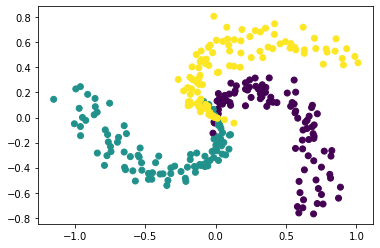

Loss epoch 0 : 1.1021286771875347
Loss epoch 1000 : 0.2037835644550996
Loss epoch 2000 : 0.1855433447442798
Loss epoch 3000 : 0.17611016514797015
Loss epoch 4000 : 0.16651697709915117
Loss epoch 5000 : 0.15224669582822958
Loss epoch 6000 : 0.13830634287186794
Loss epoch 7000 : 0.11870190498493541
Loss epoch 8000 : 0.10406408280643936
Loss epoch 9000 : 0.08840098486468793


In [16]:
iniciar(numero_clases=3, numero_ejemplos=300, graficar_datos=True)